In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


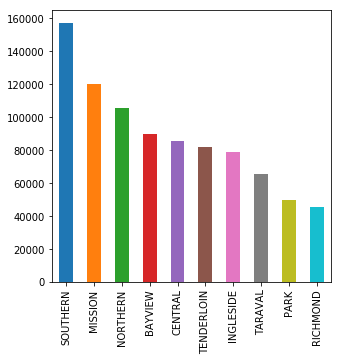

In [3]:
train.PdDistrict.value_counts().plot(kind="bar",figsize=(5,5))

In [4]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [5]:
# we don't have the Descript, Resolution, category(target) in the test dataset
# my workflow is:
# 1: drop train columns: Category, Descript, resolution, x,y
# 2: drop test columns: id,x,y
# joint(train and test)
# dealing with missing&feature engineer
# predict descript, resolution for test
# predict the category

In [6]:
# drop the columns
train_drop = train.drop(columns=["Category", "Descript", "Resolution", "X","Y"], axis=1)
test_drop = test.drop(columns=["Id","X","Y"], axis=1)
ntrain = train.shape[0]
# joint
whole_data = pd.concat(objs=[train_drop, test_drop], axis=0, ignore_index=True,sort=False)
whole_data.head()

,Dates,DayOfWeek,PdDistrict,Address
0,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST
1,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST
2,2015-05-13 23:33:00,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST
3,2015-05-13 23:30:00,Wednesday,NORTHERN,1500 Block of LOMBARD ST
4,2015-05-13 23:30:00,Wednesday,PARK,100 Block of BRODERICK ST


In [7]:
# dealing with missing
# dates has no missing
null_series = whole_data.isnull().sum()
DayOfWeek = whole_data.DayOfWeek.unique()
print(DayOfWeek)

PdDistrict = whole_data.PdDistrict.unique()
print(PdDistrict)

Address = whole_data.Address.unique()
print(Address)

['Wednesday' 'Tuesday' 'Monday' 'Sunday' 'Saturday' 'Friday' 'Thursday']
['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN']
['OAK ST / LAGUNA ST' 'VANNESS AV / GREENWICH ST'
 '1500 Block of LOMBARD ST' ... 'DE LONG ST / RHINE ST'
 'DAGGETT ST / MISSOURI ST' 'LOWER GREAT HY / PACHECO ST']


Year    2003    2004    2005    2006    2007    2008    2009    2010    2011  \
Week                                                                           
1     3208.0  1512.0  2598.0  2623.0  3121.0  3541.0  1686.0  2441.0  2603.0   
2     2849.0  2841.0  2934.0  2682.0  2628.0  2709.0  2692.0  2692.0  2664.0   
3     2721.0  2996.0  2825.0  2607.0  2602.0  2853.0  2729.0  2457.0  2562.0   
4     2982.0  3097.0  2735.0  2593.0  2466.0  2473.0  2580.0  2487.0  2511.0   
5     2999.0  3010.0  2916.0  2678.0  2745.0  2578.0  2659.0  2630.0  2625.0   

Year    2012    2013    2014    2015  
Week                                  
1     2941.0  3278.0  3202.0  1621.0  
2     2711.0  2743.0  2820.0  2892.0  
3     2360.0  2847.0  3074.0  3123.0  
4     2746.0  2969.0  2960.0  2974.0  
5     2690.0  2994.0  2787.0  3022.0  


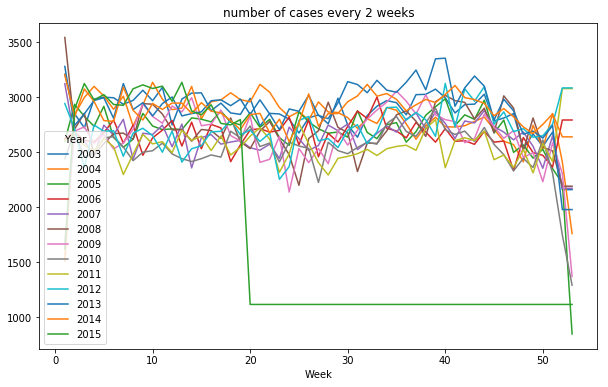

In [25]:
# feature engineering(dates)
whole_data.Dates = pd.to_datetime(whole_data.Dates)
whole_data["Year"] = whole_data.Dates.dt.year
whole_data["Month"] = whole_data.Dates.dt.month
whole_data["Day"] = whole_data.Dates.dt.day
whole_data["Hours"] = whole_data.Dates.dt.hour
whole_data["Week"] = whole_data.Dates.dt.week

whole_data['event']=1
weekly_events = whole_data[['Week','Year','event']].groupby(['Year','Week']).count().reset_index()
weekly_events_years = weekly_events.pivot(index='Week', columns='Year', values='event').fillna(method="ffill")
ax = weekly_events_years.interpolate().plot(title='number of cases every 2 weeks', figsize=(10,6))
print(weekly_events_years.interpolate().head())
# feature engineering(Adress)
street = whole_data.Address.str.rsplit(n=2,expand=True)
whole_data["Street"] = street.loc[:,1]

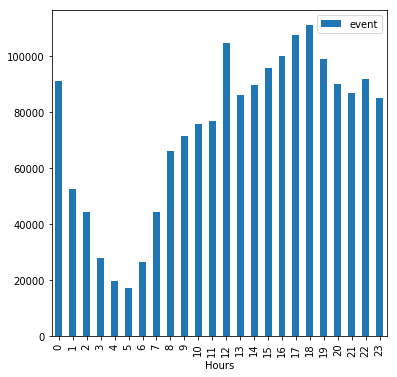

In [28]:
hourly_events = whole_data[['Hours','event']].groupby(['Hours']).count()
hourly_events.plot(kind='bar', figsize=(6, 6))

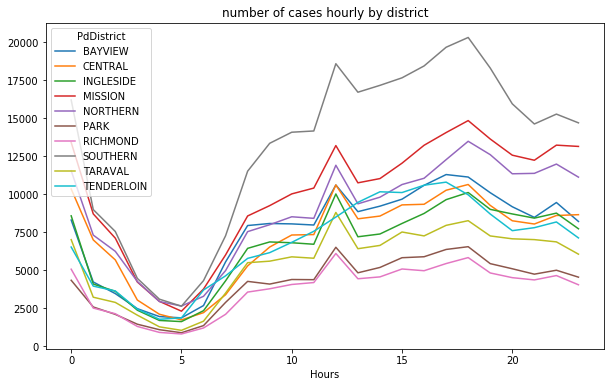

In [30]:
hourly_district_events = whole_data[['PdDistrict','Hours','event']].groupby(['PdDistrict','Hours']).count().reset_index()
hourly_district_events_pivot = hourly_district_events.pivot(index='Hours', columns='PdDistrict', values='event').fillna(method='ffill')
hourly_district_events_pivot.interpolate().plot(title='number of cases hourly by district', figsize=(10,6))

In [8]:
print(len(whole_data.Month.unique()))
print(len(whole_data.Day.unique()))
print(len(whole_data.Hours.unique()))
whole_data.Hours.unique()

12
31
24


array([23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,
        6,  5,  4,  3,  2,  1,  0], dtype=int64)

In [9]:
whole_data["Hours_Cat"] = pd.cut(whole_data.Hours, bins=[-1,6,9,12,18,25], labels=["early morning", "morning", "noon", "afternoon",
                                                                                 "evening"])
whole_data["Day_Cat"] = pd.cut(whole_data.Day, bins=[0,11,21,32], labels=["early","mid","late"])

hours_dict = {
    "early morning": 1, "morning":2, "noon":3, "afternoon":4, "evening":5
}

day_dict = {
    "early":1, "mid":2, "late":3
}

whole_data.Hours_Cat = whole_data.Hours_Cat.map(hours_dict)
whole_data.Day_Cat = whole_data.Day_Cat.map(day_dict)
whole_data.drop(columns=["Day","Hours","Address"],axis=1,inplace=True)
whole_data.head()

,DayOfWeek,PdDistrict,Year,Month,Street,Hours_Cat,Day_Cat
0,Wednesday,NORTHERN,2015,5,LAGUNA,5,2
1,Wednesday,NORTHERN,2015,5,LAGUNA,5,2
2,Wednesday,NORTHERN,2015,5,GREENWICH,5,2
3,Wednesday,NORTHERN,2015,5,LOMBARD,5,2
4,Wednesday,PARK,2015,5,BRODERICK,5,2


In [10]:
columns = ["DayOfWeek", "PdDistrict","Year","Month","Street"]
lbl = LabelEncoder()
for c in columns:
    lbl.fit(whole_data[c])
    whole_data[c] = lbl.transform(whole_data[c])
    
whole_data.head()

,DayOfWeek,PdDistrict,Year,Month,Street,Hours_Cat,Day_Cat
0,6,4,12,4,1022,5,2
1,6,4,12,4,1022,5,2
2,6,4,12,4,801,5,2
3,6,4,12,4,1093,5,2
4,6,5,12,4,273,5,2


In [11]:
# predict the "descript", no granularity on the train
train_descript = whole_data[:ntrain].copy()
test_descript = whole_data[ntrain:]

train_descript["Descript"] = lbl.fit(train.Descript).transform(train.Descript)
features = ["DayOfWeek","PdDistrict","Year","Month","Street","Hours_Cat","Day_Cat"]
target = "Descript"
train_X, test_X, train_y, test_y = train_test_split(train_descript[features], train_descript[target],test_size=0.2, random_state=42)
train_descript.head()

,DayOfWeek,PdDistrict,Year,Month,Street,Hours_Cat,Day_Cat,Descript
0,6,4,12,4,1022,5,2,866
1,6,4,12,4,1022,5,2,810
2,6,4,12,4,801,5,2,810
3,6,4,12,4,1093,5,2,404
4,6,5,12,4,273,5,2,404


In [14]:
# random descision tree
clf_RF = RandomForestClassifier()
# cv_score = cross_val_score(clf_RF, train_X, train_y,scoring="roc_auc",cv=5).mean()
clf_RF.fit(train_X,train_y)
# score = roc_auc_score(predictions, test_y)


E:\AnacondaModule\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


MemoryError: could not allocate 3653238784 bytes